# Management and Analysis of Physics Datasets

## *Session 2*

#### Federico Agostini, Federico Bottaro

### Part A

Both *GRID* and *Cloud* are built around a Virtual Organization (VO), that for example provides authentication and authorization for users.

*GRID* is a midware structure: it is modeled in order to make to communicate different architectures through a set of code that works on different layers. In particular, *GRID* architecture can be decomposed in 5 layers:
- **Fabric**: hardware resources (computing and storage), networks and code repositories.
- **Connectivity**: set of software that manage communication/authentication protocols, along with security ones. This layer for example can decide whether a VO should be ban.
- **Resource**: software and protocols to monitor *GRID* structures; for example it manages publication of data, access to them, negotiation (job queuing and priority), resource monitoring, accounting.
- **Collective**: coordination of services not strictly correlated to single resources; it focuses on interactions between them, such as allocating, scheduling and brokering.
- **Application**: it denotes anything a user may want to execute and can be seen as the user interface to access the *GRID*.

*Clouds* are large pool of computing and/or storage resources, which can be accessed via standard protocols through an abstract interface. The structure follows a 4 layer architecture:
- **Fabric**: hardware components, same as in the *GRID*.
- **Unified resource**: abstraction of resources (usually through virtualization) to make them available to higher level application and end users.
- **Platform**: specialized tools, middleware and services to provide a development/deployment platform.
- **Application**: softwares that runs in the *Cloud*

*GRID* and *Cloud* are two aspects of distributed computing, which have some common features, along with different aspects. *GRID* architecture is composed by machines from different locations, that aim to satisfy a common task. The problem is hence divided in subtasks that are sent to the different resources. *Cloud* on the other hand centralizes resources and the user interfaces with the system with an environment developed in order to be easily accessed (for example through Internet).

### Part B (Agostini)

In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import IPython.display as display

import dask_ml
from dask_ml.preprocessing import MinMaxScaler
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import Incremental
from dask_ml.wrappers import ParallelPostFit
from sklearn.neural_network import MLPClassifier

%matplotlib inline

In [2]:
def analyses(client_name):
    # Scale up: connect to your own cluster with more resources
    print("Connect to cluster ...", end=" ")
    client = Client(client_name)
    display.display(client)
    print("DONE")
    # load remote datadet
    print("Loading remote dataset ...", end=" ")
    df = dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1')
    print("DONE")
    # count number of example for each letter
    print("Counting number of occurences for each letter ...", end=" ")
    letter_counts = df.groupby(['letter'])['letter'].count().compute()
    # plot number of example for each letter
    plt.figure(figsize=(8,5))
    letter_counts.plot(kind="barh")
    plt.show()
    print("DONE")
    # try different repartitions and record the time to count the number of examples for each letter
    print("Trying with different repartitions ...")
    repartitions = [1,2,5,10,20,50]
    t = []
    for r in repartitions:
        print("\t", r, "repartitions ...", end=" ")
        df_rep = df.repartition(npartitions=r)
        t1 = time.time()
        letter_counts = df_rep.groupby(['letter'])['letter'].count().compute()
        t2 = time.time()
        t.append(t2-t1)
        print("DONE")
    # plot time as function of the number of repartitions
    plt.figure(figsize=(8,5))
    plt.plot(repartitions, t, 'o--')
    plt.xlabel("# partitions")
    plt.ylabel("time (s)")
    plt.show()
    
    # filter date and get only rows for letter 'A' or 'Z'
    print("Filtering data ...", end=" ")
    selection = df['letter'].isin(['a','z'])
    df_AZ = df[selection]
    # computational graph
    display.display(df_AZ.visualize(rankdir="LR"))
    print("DONE")
    # split dataset in training (80%) and test (20%)
    print("Splitting in train (80%) and test set (20%) ...", end=" ")
    X = df_AZ.iloc[:, 2:].to_dask_array(True)
    y = df_AZ['label'].to_dask_array(True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    print("DONE")
    # preprocess data with 'MinMaxScaler'
    print("Preprocessing data ... ", end=" ")
    transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
    transformer.fit(X_train)
    X_train = transformer.transform(X_train)
    X_test = transformer.transform(X_test)
    print("DONE")
    # create the 'MLPClassifier'
    estimator = MLPClassifier(random_state=42, #put your code
                              max_iter=1000, 
                              hidden_layer_sizes=(200, 200), 
                              activation='relu', 
                              solver='adam', alpha=0.0001, 
                              batch_size='auto', 
                              learning_rate_init=0.001, 
                              shuffle=True, 
                              tol=0.0001, 
                              validation_fraction=0.1)
    t1 = time.time()
    # training the classifier using the 'IncrementalLearning'
    print("Training MLPClassifier ...", end=" ")
    clf = Incremental(estimator)
    clf.fit(X_train, y_train, classes=[0,25])
    print("DONE")
    # make predictions using 'ParallelPostFit'
    print("Making predictions ...")
    ppf =  ParallelPostFit(estimator=clf.estimator_, scoring='accuracy')
    t2 = time.time()
    # print accuracy and time needed to train and make predictions
    print("\t Accuracy: "+str(dask_ml.metrics.accuracy_score(y_test, ppf.predict(X_test))))
    print("\t Time elapsed (s):", t2-t1)
    print("DONE")


#### *2 workers*

Running with 2 workers
----------------------
Connect to cluster ... 

Client Scheduler: tcp://10.190.1.67:8786 Dashboard: http://10.190.1.67:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.15 GB


DONE
Loading remote dataset ... DONE
Counting number of occurences for each letter ... 

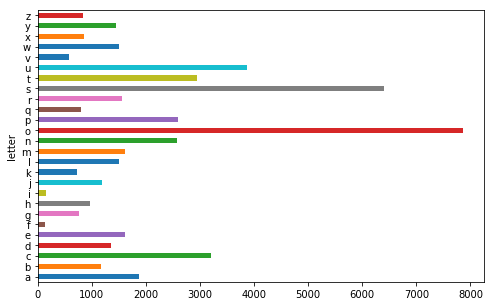

DONE
Trying with different repartitions ...
	 1 repartitions ... DONE
	 2 repartitions ... DONE
	 5 repartitions ... DONE
	 10 repartitions ... DONE
	 20 repartitions ... DONE
	 50 repartitions ... DONE


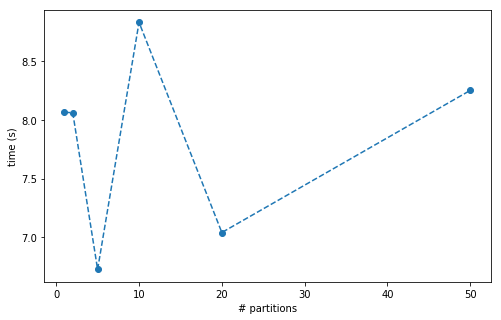

Filtering data ... 

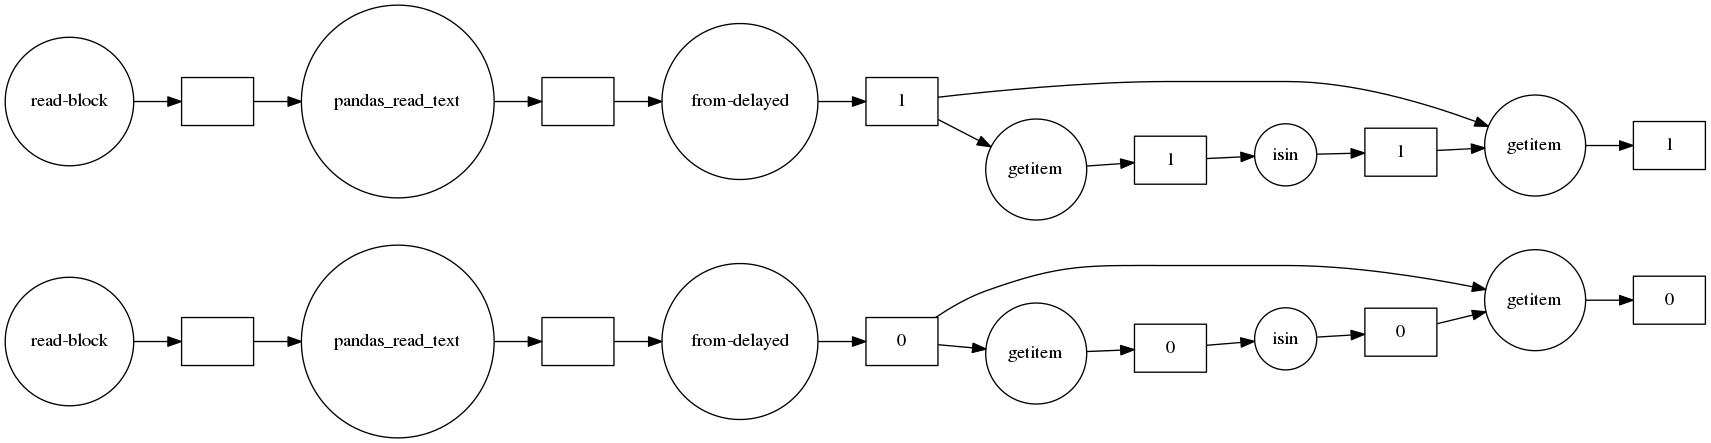

DONE
Splitting in train (80%) and test set (20%) ... DONE
Preprocessing data ...  DONE
Training MLPClassifier ... DONE
Making predictions ...
	 Accuracy: 0.7800369685767098
	 Time elapsed (s): 8.002979755401611
DONE
----------------------
Time elapsed (s) = 111.20783948898315


In [3]:
client_name = "10.190.1.67:8786"

print("Running with 2 workers")
print("----------------------")
t_start = time.time()

analyses(client_name)

t_end = time.time()
print("----------------------")
print("Time elapsed (s) =", t_end-t_start)

Execution times to count the number of examples for each alphabet character as function of the number of partitions seems to be quite randomic. Our dataset is about 90 MB, so the best choice would be to work locally because its size largely fits into the RAM. Splitting into different chuncks introduces overhead due to the fact that the different components of the cluster need to communicate.

If we choose a small number of chuncks, their size could not fit in a worker memory at once; clearly, this is not our case (due to the dataset size). In addition, having a small number of chuncks, which size is random, may mean that one worker finishes earlier than the other, so there is some amount of time where only one of the two workers is actually doing something.

On the other hand, if we prefer a great number of chuncks we introduce a large overhead, due to the amount of tasks we are sending.

---


The computational graph of the data filtering shows that the operations are done at the same time in the two chuncks (that is the default value). If we had a different number of partitions N, the graph would show N equal diagrams, each one related to one chunck. 


#### *4 workers*

Running with 4 workers
----------------------
Connect to cluster ... 

Client Scheduler: tcp://10.190.1.67:8786 Dashboard: http://10.190.1.67:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.31 GB


DONE
Loading remote dataset ... DONE
Counting number of occurences for each letter ... 

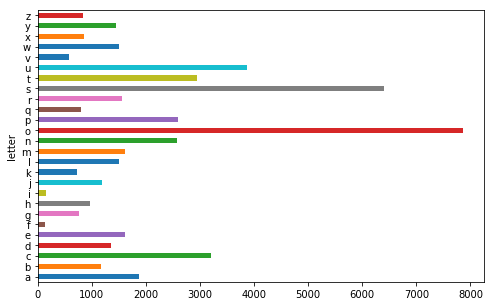

DONE
Trying with different repartitions ...
	 1 repartitions ... DONE
	 2 repartitions ... DONE
	 5 repartitions ... DONE
	 10 repartitions ... DONE
	 20 repartitions ... DONE
	 50 repartitions ... DONE


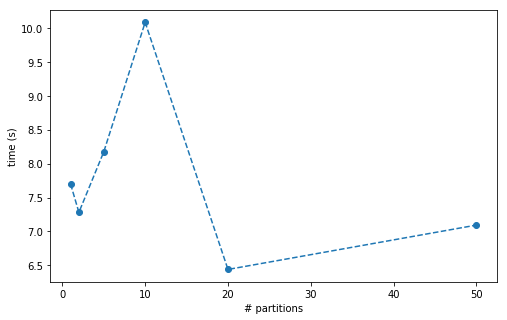

Filtering data ... 

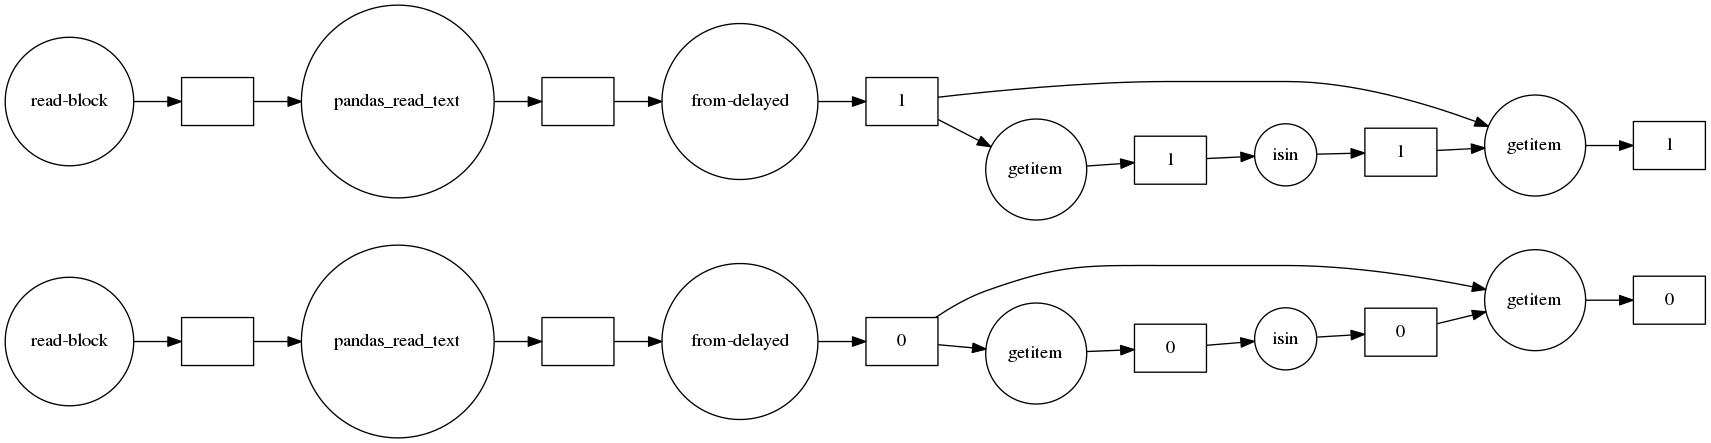

DONE
Splitting in train (80%) and test set (20%) ... DONE
Preprocessing data ...  DONE
Training MLPClassifier ... DONE
Making predictions ...
	 Accuracy: 0.7800369685767098
	 Time elapsed (s): 8.199056386947632
DONE
----------------------
Time elapsed (s) = 101.08885431289673


In [4]:
client_name = "10.190.1.67:8786"

print("Running with 4 workers")
print("----------------------")
t_start = time.time()

analyses(client_name)

t_end = time.time()
print("----------------------")
print("Time elapsed (s) =", t_end-t_start)

#### *6 workers*

Running with 6 workers
----------------------
Connect to cluster ... 

Client Scheduler: tcp://10.190.1.67:8786 Dashboard: http://10.190.1.67:8787/status,Cluster Workers: 6 Cores: 12 Memory: 24.46 GB


DONE
Loading remote dataset ... DONE
Counting number of occurences for each letter ... 

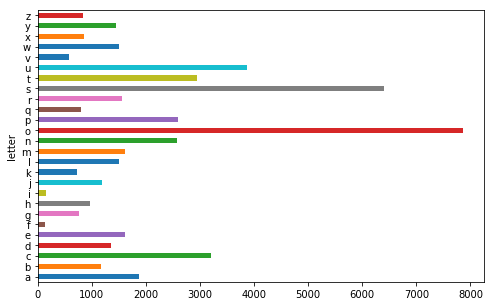

DONE
Trying with different repartitions ...
	 1 repartitions ... DONE
	 2 repartitions ... DONE
	 5 repartitions ... DONE
	 10 repartitions ... DONE
	 20 repartitions ... DONE
	 50 repartitions ... DONE


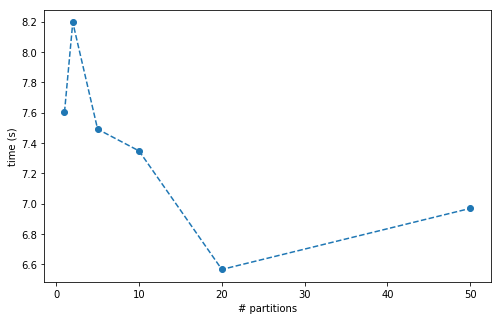

Filtering data ... 

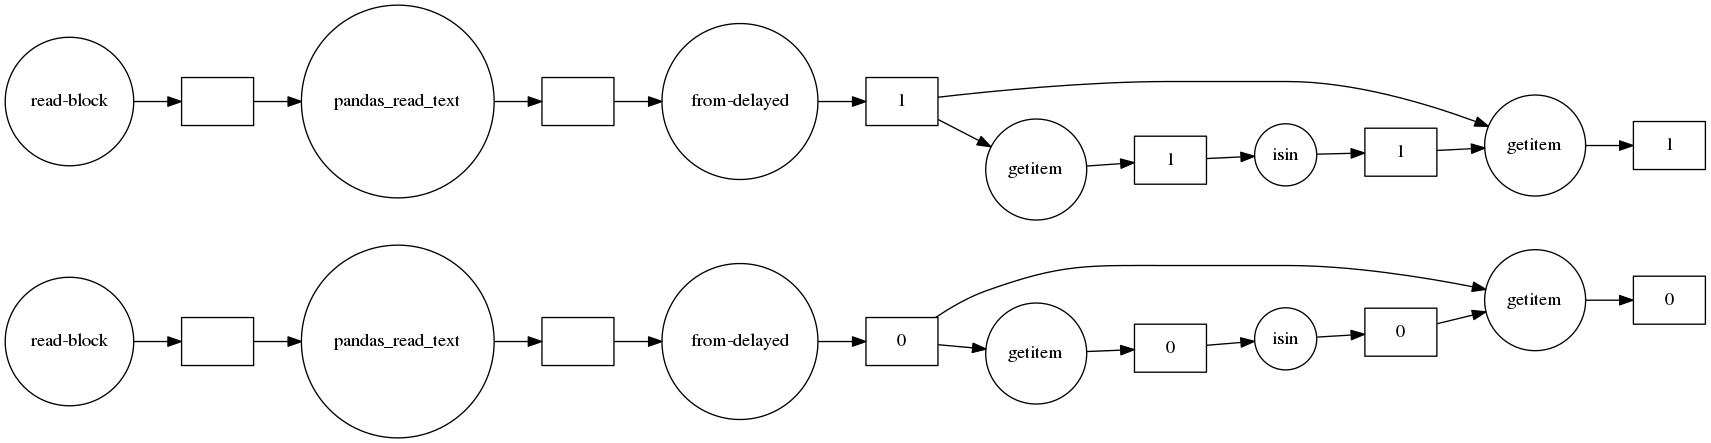

DONE
Splitting in train (80%) and test set (20%) ... DONE
Preprocessing data ...  DONE
Training MLPClassifier ... DONE
Making predictions ...
	 Accuracy: 0.7800369685767098
	 Time elapsed (s): 8.163461208343506
DONE
----------------------
Time elapsed (s) = 101.82724213600159


In [5]:
client_name = "10.190.1.67:8786"

print("Running with 6 workers")
print("----------------------")
t_start = time.time()

analyses(client_name)

t_end = time.time()
print("----------------------")
print("Time elapsed (s) =", t_end-t_start)

#### *8 workers*

Running with 8 workers
----------------------
Connect to cluster ... 

Client Scheduler: tcp://10.190.1.67:8786 Dashboard: http://10.190.1.67:8787/status,Cluster Workers: 8 Cores: 16 Memory: 32.62 GB


DONE
Loading remote dataset ... DONE
Counting number of occurences for each letter ... 

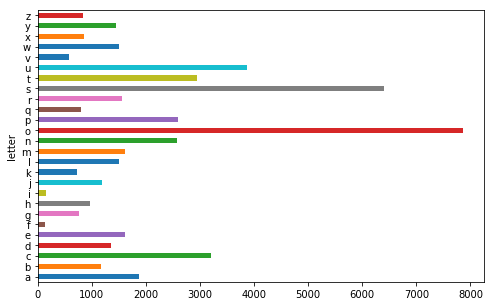

DONE
Trying with different repartitions ...
	 1 repartitions ... DONE
	 2 repartitions ... DONE
	 5 repartitions ... DONE
	 10 repartitions ... DONE
	 20 repartitions ... DONE
	 50 repartitions ... DONE


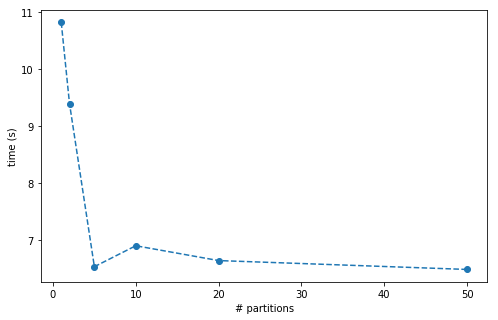

Filtering data ... 

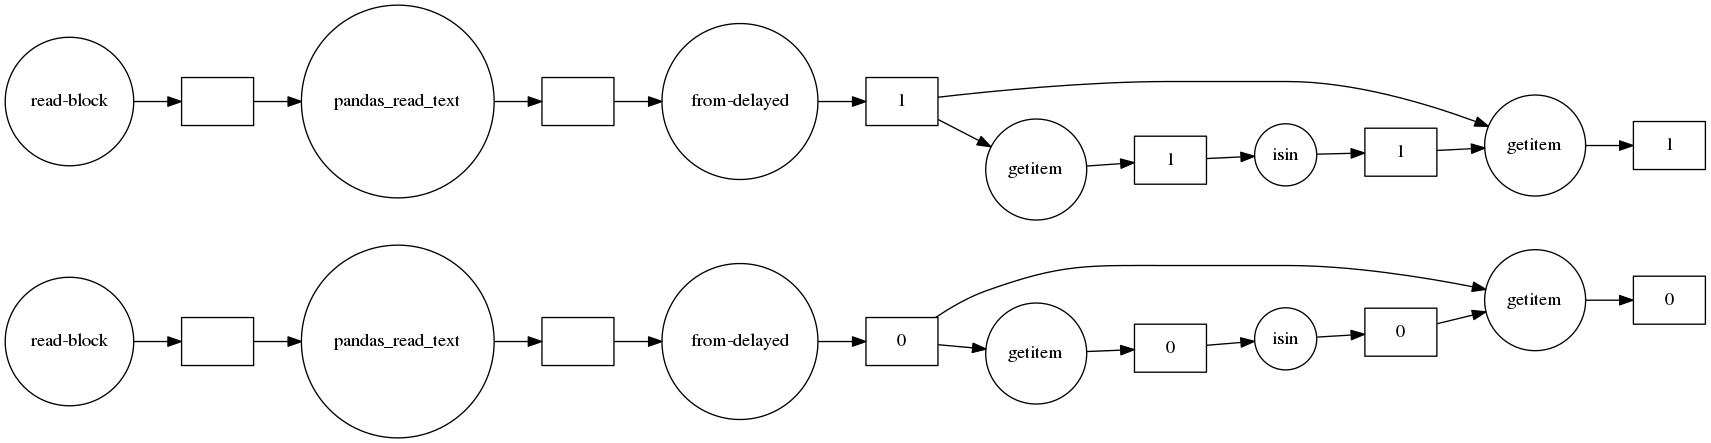

DONE
Splitting in train (80%) and test set (20%) ... DONE
Preprocessing data ...  DONE
Training MLPClassifier ... DONE
Making predictions ...
	 Accuracy: 0.7800369685767098
	 Time elapsed (s): 9.945612907409668
DONE
----------------------
Time elapsed (s) = 99.46150398254395


In [6]:
client_name = "10.190.1.67:8786"

print("Running with 8 workers")
print("----------------------")
t_start = time.time()

analyses(client_name)

t_end = time.time()
print("----------------------")
print("Time elapsed (s) =", t_end-t_start)

#### *10 workers*

Running with 10 workers
-----------------------
Connect to cluster ... 

Client Scheduler: tcp://10.190.1.67:8786 Dashboard: http://10.190.1.67:8787/status,Cluster Workers: 10 Cores: 20 Memory: 40.77 GB


DONE
Loading remote dataset ... DONE
Counting number of occurences for each letter ... 

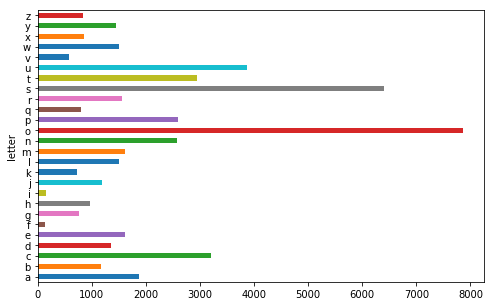

DONE
Trying with different repartitions ...
	 1 repartitions ... DONE
	 2 repartitions ... DONE
	 5 repartitions ... DONE
	 10 repartitions ... DONE
	 20 repartitions ... DONE
	 50 repartitions ... DONE


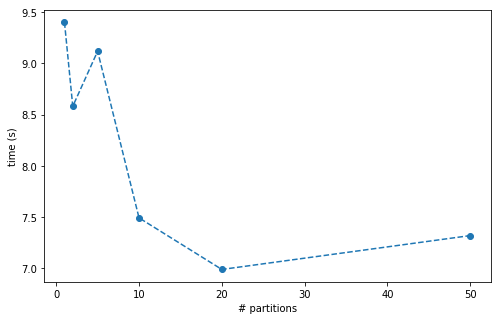

Filtering data ... 

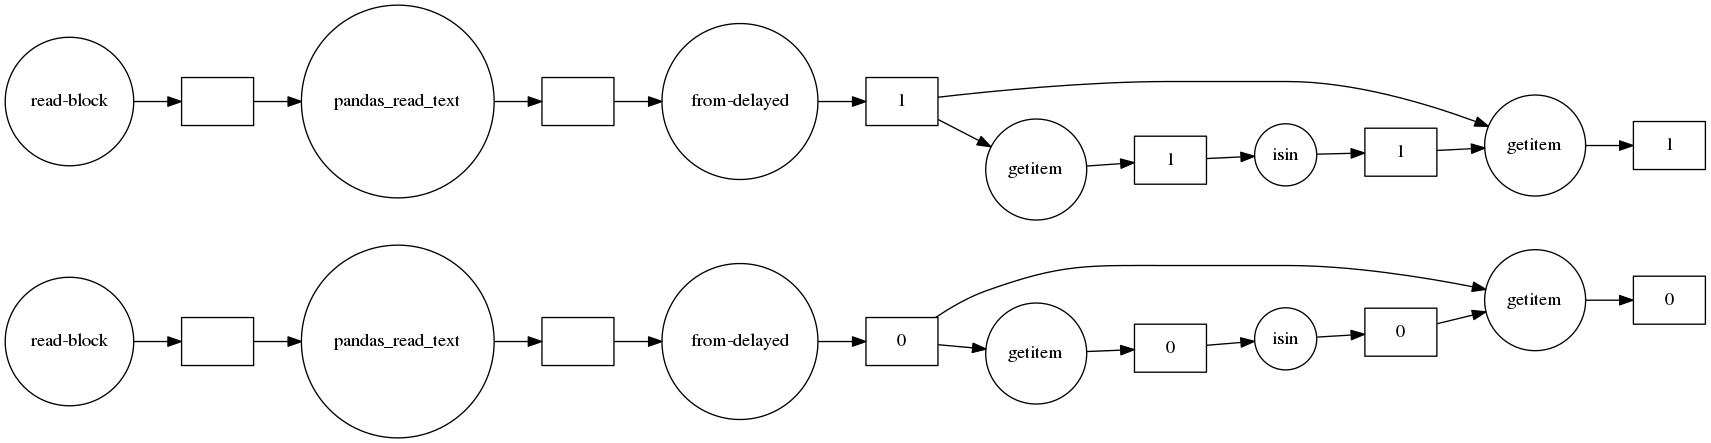

DONE
Splitting in train (80%) and test set (20%) ... DONE
Preprocessing data ...  DONE
Training MLPClassifier ... DONE
Making predictions ...
	 Accuracy: 0.9759704251386322
	 Time elapsed (s): 8.591697216033936
DONE
-----------------------
Time elapsed (s) = 100.35547733306885


In [7]:
client_name = "10.190.1.67:8786"

print("Running with 10 workers")
print("-----------------------")
t_start = time.time()

analyses(client_name)

t_end = time.time()
print("-----------------------")
print("Time elapsed (s) =", t_end-t_start)

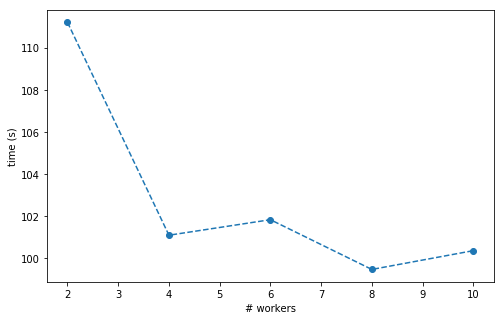

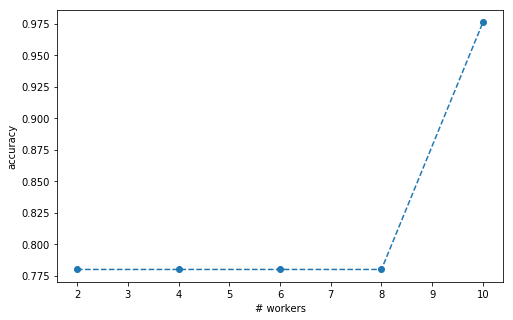

,Workers,Time (s),Accuracy
0,2,111.208,0.780
1,4,101.089,0.780
2,6,101.827,0.780
3,8,99.462,0.780
4,10,100.355,0.976


In [18]:
import pandas as pd

n_workers    = [2, 4, 6, 8, 10]
time_elapsed = [111.208, 101.089, 101.827, 99.462, 100.355]
accuracy     = [0.780, 0.780, 0.780, 0.780, 0.976]


plt.figure(figsize=(8,5))
plt.plot(n_workers, time_elapsed, 'o--')
plt.xlabel("# workers")
plt.ylabel("time (s)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(n_workers, accuracy, 'o--')
plt.xlabel("# workers")
plt.ylabel("accuracy")
plt.show()

table = pd.DataFrame({"Workers": n_workers, "Time (s)":time_elapsed, "Accuracy": accuracy})
display.display(table)


With a number of workers greater then 2, the time required is smaller, but it seems to fluctuate when we have 4, 6, 8, 10 workers; this can be explained with same arguments proposed in the previous comment.

The accuracy is the same when we use 2, 4, 6, 8 workers, than increases with 10 workers. However, this is also a random result, looking at the results obtained by my colleagues. In addition, there can be a different splitting of the data during the training procedure, because of the use of the incremental learning feature, that can produce different data batches.

#### *Tensorflow*

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
from dask_tensorflow import start_tensorflow


Using TensorFlow backend.


In [9]:
client_name = "10.190.1.67:8786"
client = Client(client_name)
display.display(client)
tf_spec, dask_spec = start_tensorflow(client, ps=5, worker=5) # sum ps+worker = number of workers in cluster

Client Scheduler: tcp://10.190.1.67:8786 Dashboard: http://10.190.1.67:8787/status,Cluster Workers: 10 Cores: 20 Memory: 40.77 GB


In [10]:
# load remote datadet
df = dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1')
df = df.repartition(npartitions=4)

# filter date and get only rows for letter 'A' or 'Z'
selection = df['letter'].isin(['a','z'])
df_AZ = df[selection]

# split dataset in training (80%) and test (20%)
X = df_AZ.iloc[:, 2:].values.compute()#.to_dask_array(True)
y = df_AZ['label'].values.compute()#.to_dask_array(True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# preprocess data with 'MinMaxScaler'
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train)
X_train = transformer.transform(X_train)
X_test  = transformer.transform(X_test)
y_train[y_train == 25] = 1
y_test [y_test == 25]  = 1

# reshape data
X_train = X_train.reshape((len(X_train),28,28,1))
X_test  =  X_test.reshape((len(X_test), 28,28,1))

Mixture of types in 'arrays'. Falling back to scikit-learn.


In [11]:
def build_deep_cnn_neural_network():
    # create model
    
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), name='c', strides=(1, 1), padding='valid', activation='relu', input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='d'))
    model.add(Dense(32, activation='relu', name='d1'))
    model.add(Dense(1, activation='sigmoid', name='d2'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
model = build_deep_cnn_neural_network()
model.fit(X_train, y_train, verbose=1, epochs=10, batch_size=32)
#print(model.predict(X_test))
scores = model.evaluate(X_test,y_test, verbose=1)
print("Accuracy: "+str(scores[1]))

Epoch 1/10
2161/2161 [==============================] - 7s 3ms/step - loss: 0.0673 - acc: 0.9773
Epoch 2/10
2161/2161 [==============================] - 6s 3ms/step - loss: 0.0086 - acc: 0.9972
Epoch 3/10
2161/2161 [==============================] - 6s 3ms/step - loss: 0.0017 - acc: 1.0000
Epoch 4/10
2161/2161 [==============================] - 6s 3ms/step - loss: 2.6825e-04 - acc: 1.0000
Epoch 5/10
2161/2161 [==============================] - 6s 3ms/step - loss: 1.5352e-04 - acc: 1.0000
Epoch 6/10
2161/2161 [==============================] - 6s 3ms/step - loss: 1.0270e-04 - acc: 1.0000
Epoch 7/10
2161/2161 [==============================] - 6s 3ms/step - loss: 7.4823e-05 - acc: 1.0000
Epoch 8/10
2161/2161 [==============================] - 6s 3ms/step - loss: 5.6803e-05 - acc: 1.0000
Epoch 9/10
2161/2161 [==============================] - 6s 3ms/step - loss: 4.3039e-05 - acc: 1.0000
Epoch 10/10
541/541 [==============================] - 0s 891us/step
Accuracy: 0.9981515711645101


### Part B (Bottaro)

In [1]:
import os
import dask
from distributed import Client
import dask.dataframe as dd
from time import time as tic
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
import sklearn.cluster
import dask_ml.cluster
from dask_ml.model_selection import train_test_split
from dask_ml.datasets import make_classification
from dask_ml.wrappers import ParallelPostFit
from dask_ml.wrappers import Incremental
from dask_ml.preprocessing import MinMaxScaler

#### *Punto 1: creazione cluster*

Dal terminale invio i comandi :
- dask-scheduler
- dask-worker "IP" --nprocs 2

In [2]:
ttot1=tic() # tempo di inizio

client = Client('10.190.1.68:8786')
client

Client Scheduler: tcp://10.190.1.68:8786 Dashboard: http://10.190.1.68:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.15 GB


#### *Punto 2: caricamento dati*

In [3]:
df = dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1')

#### *Punto 3: descrizione visiva dei dati*

In [4]:
count = df.groupby(['letter']).letter.count().compute()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

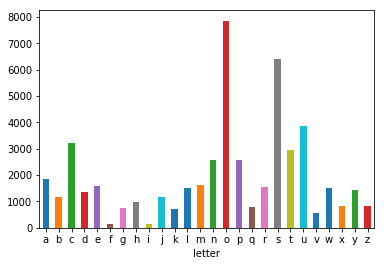

In [5]:
count.plot(kind='bar')
plt.xticks(rotation=0)

#### *Punto 4: valutazione dei tempi del punto 3 in base alle partizioni dei dati*

In [6]:
n_part =[1,2,3,4,5,6,7,8,16,32]
time_count= []

for i in n_part:
    df1 = df.repartition(npartitions=i)
    t_start = tic()
    count1  = df1.groupby(['letter']).letter.count().compute()
    t_stop  = tic()
    time_count.append(t_stop-t_start)
    
#time_count

Text(0, 0.5, 'Time (s)')

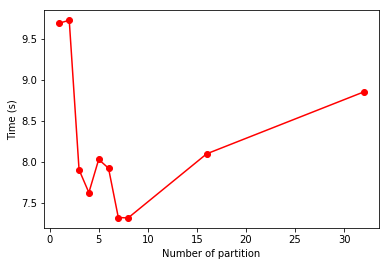

In [7]:
plt.plot(n_part,time_count,'o-', color='r')
plt.xlabel('Number of partition')
plt.ylabel('Time (s)')

#### Commento: 
L'andamento del grafico e' una spezzata che non sembra far emergere un trend nella relazione numero di partizioni - tempo impiegato. Si ha inoltre che facendo piu' prove il grafico cambia radicalmente. Una spiegazione potrebbe essere data dal fatto che essendo le partizioni fatte in modo randomico, vi e' una ripetibilita' pressoche' nulla.

Nell'eventualita' in cui il dataset con cui bisogna lavorare fosse molto piu' grande di quello a disposizione, uno stodio di questo tipo potrebbe essere piu' significativo in quanto con il dataset dato (lavorabile anche in locale) bisogna tenere conto di molti fattori come ad esempio comunicazione fra i vari worker. 


#### *Punto 5: filtraggio del dataset per ottenere colonne relative solo alle lettere 'a' e 'z'*

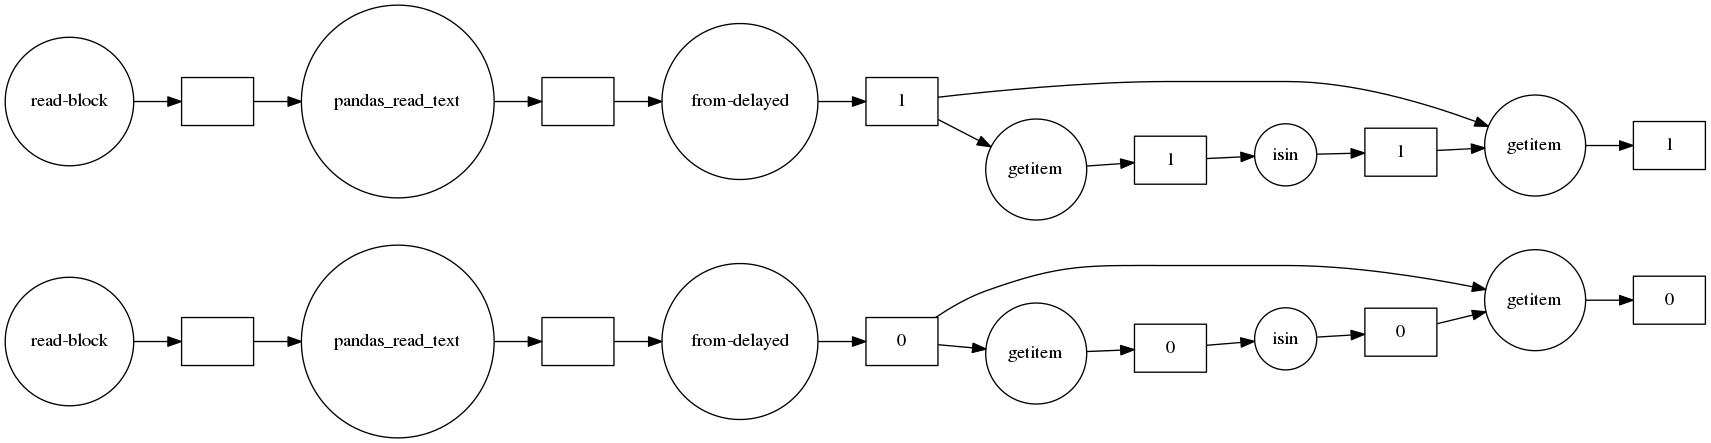

In [8]:
letter = ['a', 'z']
selected = df.letter.isin(letter)

df_a_z = df[selected]
df_a_z.visualize(rankdir="LR")

#### Commento:
Si ha che di deafault dask partiziona il dataset in due. Questo fatto e' riscontrabile nel grafico sovrastante in quanto si puo' vedere che i vari comandi vengono eseguiti in parallelo nelle due partizioni. 

Provando con un numero di partizioni maggiore si ottiene un grafico con tanti blocchi quante sono le partizioni.

#### *Punto 6: divisione del dataset in train (80%) e test (20%)*

In [9]:
from dask_ml.model_selection import train_test_split

In [10]:
X =  df_a_z.drop('letter', 1)
X =  X.drop('label', 1)

Y = df_a_z['label']

X = X.to_dask_array(True)
Y = Y.to_dask_array(True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2)

#### *Punto 7: apprendimento con neural network*

In [11]:
t1 = tic()
transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train)

t2 = tic()
print("Time: "+str(t2-t1)+"s")
X_train

Time: 7.727455377578735s


dask.array<concatenate, shape=(2161, 784), dtype=int64, chunksize=(1490, 784)>

In [12]:
from sklearn.neural_network import MLPClassifier
from dask_ml.preprocessing import MinMaxScaler

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

estimator = MLPClassifier(random_state=42, 
                          max_iter=1, 
                          hidden_layer_sizes=(200, 200 ), 
                          activation='relu', 
                          solver='adam', alpha=0.0001, 
                          batch_size='auto', 
                          learning_rate_init=0.001, 
                          shuffle=True, 
                          tol=0.0001, 
                          validation_fraction=0.1)
t1 = tic()
clf = Incremental(estimator)
clf.fit(X_train , y_train, classes=[0, 25])


clf2 = ParallelPostFit(estimator=clf.estimator_,scoring='accuracy')
t2 = tic()
print("Accuracy: "+str(sklearn.metrics.accuracy_score(y_test, clf2.predict(X_test))))
print("Time: "+str(t2-t1)+"s")
ttot2=tic()
print("Total Time: "+str(ttot2-ttot1)+"s")

Accuracy: 0.9759704251386322
Time: 8.685136795043945s
Total Time: 218.7673327922821s


#### *Punto 8: ripetizione dei punti precedenti cambiando il numero di worker*
Tabella riassuntiva dei risultati

| Numero di worker | Accuratezza | Tempo di classificazione | Tempo totale |
| --- | --- | --- | --- |
| 2 | 0.9759 | 7.52 | 125.31 |
| 4 | 0.7800 | 13.34 | 130.54 |
| 6 | 0.9759 | 10.04 | 139.19 |
| 8 | 0.9759 | 9.49 | 136.26 |
| 10 | 0.7800 | 9.10 | 141.71 |


#### Commento
Similmente a quanto esposto nel punto 4 si ha che anche questa analisi porta a un'apparente mancanza di relazione significativa tra numero di worker e accuratezza raggiunta. Si puo' riscontrare infatti che l'accuratezza varia "casualmente" cambiando il numero di worker e lo stesso comportamento si ha anche valutando il tempo impiegato. A supporto di quanto detto sono state fatte piu' prove e ad ognuna di essa si ha una fluttuazione dei risultati molto significativa (si arriva anche al 30 %). La spiegazione di quanto osservato potrebbe risiedere (come al punto 4) in vari fattori come ad esempio la casualita' di partizionamento del dataset; i tempi di comunicazione dei vari worker; i processi interni al PC... 
In oltre il fatto che il dataset a disposizione abbia dimensione abbastanza ridotta potrebbe rendere prevalenti i fattori sopra esposti.

Si rimarca il fatto che i valori esposti nella tabella sono solo valori esemplificativi e al fronte di una nuova prova tali valori potrebbero cambiare.

#### *Punto 9: apprendimento con convolutional neural network*

In [20]:
client = Client('10.190.1.68:8786')
client

Client Scheduler: tcp://10.190.1.68:8786 Dashboard: http://10.190.1.68:8787/status,Cluster Workers: 4 Cores: 8 Memory: 16.31 GB


In [21]:
from dask_tensorflow import start_tensorflow
tf_spec, dask_spec = start_tensorflow(client, ps=2, worker=2)

In [22]:
from dask_ml.preprocessing import MinMaxScaler
df = dd.read_csv('https://www.dropbox.com/s/75aqeywzxsu6hqt/dataset_sampled_handwritten.csv?dl=1')

letter = ['a', 'z']
selected = df.letter.isin(letter)
df_a_z = df[selected]

X =  df_a_z.drop('letter', 1)
X =  X.drop('label', 1)
Y = df_a_z['label']
X = X.values.compute()#to_dask_array(True)
Y = Y.values.compute()#.to_dask_array(True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2)
X_train, X_test = X_train.reshape((len(X_train), 28,28,1)),  X_test.reshape((len(X_test), 28,28,1))

transformer = MinMaxScaler(feature_range=(0, 1), copy=True)
transformer.fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

Mixture of types in 'arrays'. Falling back to scikit-learn.


In [23]:
y_train[y_train==25]=1
y_test[y_test==25]=1

In [24]:
from keras.layers import Conv2D
from keras.layers import Flatten
from dask.distributed import Client
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
from dask_ml.datasets import make_classification

def build_deep_cnn_neural_network():
    # create model
    
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), name='c', strides=(1, 1), padding='valid', activation='relu', input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', name='d'))
    #model.add(Dropout(0.2))
    model.add(Dense(28, activation='relu', name='d1'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', name='d2'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



from sklearn.metrics import accuracy_score
from keras.layers import Dropout
model = build_deep_cnn_neural_network()


model.fit(X_train, y_train, verbose=1, epochs=10, batch_size=32)
scores = model.evaluate(X_test,y_test, verbose=1)
print("Accuracy: "+str(scores[1]))

Using TensorFlow backend.


Epoch 1/10
2161/2161 [==============================] - 6s 3ms/step - loss: 0.0669 - acc: 0.9741
Epoch 2/10
2161/2161 [==============================] - 6s 3ms/step - loss: 0.0070 - acc: 0.9981
Epoch 3/10
2161/2161 [==============================] - 6s 3ms/step - loss: 7.4832e-04 - acc: 1.0000
Epoch 4/10
2161/2161 [==============================] - 6s 3ms/step - loss: 2.3681e-04 - acc: 1.0000
Epoch 5/10
2161/2161 [==============================] - 6s 3ms/step - loss: 1.3459e-04 - acc: 1.0000
Epoch 6/10
2161/2161 [==============================] - 6s 3ms/step - loss: 8.2485e-05 - acc: 1.0000
Epoch 7/10
2161/2161 [==============================] - 6s 3ms/step - loss: 5.7517e-05 - acc: 1.0000
Epoch 8/10
2161/2161 [==============================] - 6s 3ms/step - loss: 4.2199e-05 - acc: 1.0000
Epoch 9/10
2161/2161 [==============================] - 6s 3ms/step - loss: 3.1185e-05 - acc: 1.0000
Epoch 10/10
541/541 [==============================] - 0s 714us/step
Accuracy: 0.9944547134935305
